<a href="https://colab.research.google.com/github/shkim1224/colab-test/blob/main/tflite_sinewave_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.1

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.1`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
from tensorflow.keras import layers

In [4]:
!python --version
print(np.__version__)
print(tf.__version__)
print(tf.keras.__version__)

Python 3.7.11
1.19.5
2.6.0
2.6.0


In [5]:
# setting
nsamples = 1000
val_ratio =0.2
test_ratio = 0.2
tflite_model_name = 'sine_model'  #will be given .tflite suffix
c_model_name = "sine_model"  #will be given .h suffix

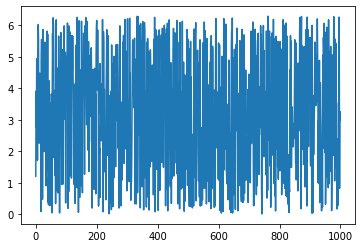

In [6]:
# generate some randeom samples
np.random.seed(1234)
x_values = np.random.uniform(low=0, high=(2*math.pi),size=nsamples)
plt.plot(x_values)

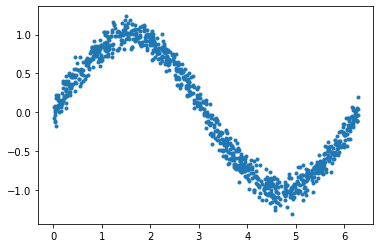

In [11]:
#create a noisy sinewave with these values
y_values= np.sin(x_values) + (0.1* np.random.randn(x_values.shape[0]))
plt.plot(x_values,y_values,'.')

In [14]:
# plot the dataset into training, validation and test sets
val_split = int(val_ratio * nsamples)
test_split = int(val_split + (test_ratio*nsamples))
x_val, x_test, x_train = np.split(x_values, [val_split, test_split])
y_val, y_test, y_train = np.split(y_values,[val_split,test_split])

assert(x_train.size + x_val.size + x_test.size) == nsamples



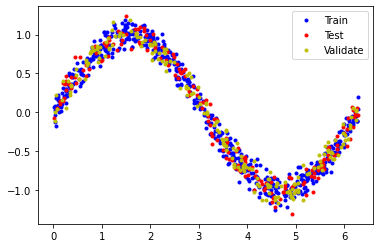

In [16]:
# plot the data 
plt.plot(x_train, y_train,'b.',label="Train")
plt.plot(x_test, y_test,'r.',label="Test")
plt.plot(x_val, y_val, 'y.',label="Validate")
plt.legend()
plt.show()

In [21]:
# create model
model = tf.keras.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(1,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1))

In [22]:
# view model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                32        
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________


In [24]:
# Add optimizer, loss function, and metrics to model and compile it
model.compile(optimizer='rmsprop',loss="mae",metrics=["mae"])

In [ ]:
history = model.fit(x_train,
                    y_train,
                    epochs=500,
                    batch_size=100,
                    validation_data=(x_val,y_val))

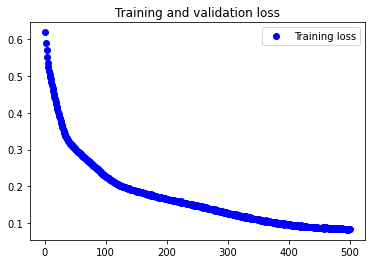

In [27]:
# plot the training history
loss = history.history['loss']
val_los = history.history['val_loss']
epochs = range(1,len(loss)+1)
plt.plot(epochs, loss, 'bo',label='Training loss')
#plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

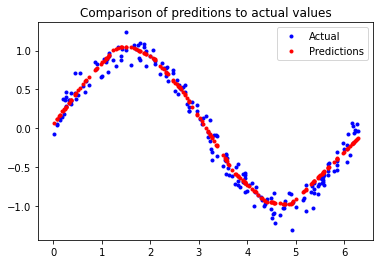

In [30]:
# plot predictions against actual values
predictions = model.predict(x_test)
plt.clf()
plt.title("Comparison of preditions to actual values")
plt.plot(x_test,y_test,'b.',label='Actual')
plt.plot(x_test, predictions, 'r.', label= "Predictions")
plt.legend()
plt.show()

In [33]:
# convert keras model to a tflite model
convert = tf.lite.TFLiteConverter.from_keras_model(model)
convert.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = convert.convert()
open(tflite_model_name + '.tflite','wb').write(tflite_model)


INFO:tensorflow:Assets written to: /tmp/tmp3r2ql7su/assets


INFO:tensorflow:Assets written to: /tmp/tmp3r2ql7su/assets


2960

In [43]:
# function : convert some hex value into an array for c programming
def hex_to_c_array(hex_data, var_name):
  c_str = ''
  # create header guard
  c_str += "#ifndef" + var_name.upper() + '_H\n'
  c_str += '#define' + var_name.upper() + '_H\n\n'
  # add array length at top of file
  c_str += '\nunsigned int' + var_name + '_len = ' + str(len(hex_data)) + ';\n'
  # declare c variable
  c_str += 'unsigned char ' + var_name + '[] = {'
  hex_array =[]
  for i, val, in enumerate(hex_data):
    hex_str = format(val, '#04x')
    if (i+1) < len(hex_data):
      hex_str += '.'
    if (i+1) % 12 == 0:
      hex_str += '\n'
    hex_array.append(hex_str)

    c_str += '\n' + format(' '.join(hex_array)) + '\n};\n\n'
    c_str += '#endif //' + var_name.upper() + '_H'
    return c_str



In [44]:
# write TFLite model to a c source (or header) file
with open(c_model_name + '.h','w') as file:
  file.write(hex_to_c_array(tflite_model,c_model_name))